<a href="https://colab.research.google.com/github/Bombbom/ML4SecurityProject/blob/main/BiLSTM-attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BiLSTM-attention

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install astor==0.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: astor
    Found existing installation: astor 0.8.1
    Uninstalling astor-0.8.1:
      Successfully uninstalled astor-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires astor~=0.8.1, but you have astor 0.7.1 which is incompatible.


In [3]:
import pandas as pd
# vector_filename ="/home/bombbom/Desktop/ReChecker/reentrancy_1671_fragment_vectors.pkl"
vector_filename = "/content/drive/MyDrive/Submit/NT522_Project/dataset_10000_record_fixed_fragment_vectors.pkl"
data = pd.read_pickle(vector_filename)
# print(data)
# df.to_csv("/home/bombbom/Desktop/ReChecker/reentrancy_1671_fragment_vectors.csv")

In [4]:
from __future__ import print_function

import warnings
import numpy as np
# from keras.utils import to_categorical
# from sklearn.metrics import confusion_matrix
# from sklearn.utils import compute_class_weight
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, LSTM, ReLU, Activation
# from keras.layers.recurrent import SimpleRNN
# from keras.layers import SimpleRNN
# from keras.optimizers import Adamax
# from sklearn.model_selection import train_test_split
# from parser import parameter_parser


from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, ReLU, Activation, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adamax
from sklearn.utils import compute_class_weight
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Layer
# from models.loss_draw import LossHistory
from keras import backend as K
from keras import initializers, regularizers, constraints
from sklearn.utils import class_weight

In [5]:
import matplotlib.pyplot as plt
import keras


# save loss, acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], lw=1.5, color='r', label='train acc', marker='.', markevery=2,
                 mew=1.5)
        # loss
        plt.plot(iters, self.losses[loss_type], lw=1.5, color='g', label='train loss', marker='.', markevery=2, mew=1.5)
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], lw=1.5, color='b', label='val acc', marker='.', markevery=2,
                     mew=1.5)
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], lw=1.5, color='darkorange', label='val loss', marker='.',
                     markevery=2, mew=1.5)
        plt.grid(True)
        plt.xlim(-0.1, 10)
        plt.ylim(-0.01, 1.01)
        plt.xlabel(loss_type)
        plt.ylabel('ACC-LOSS')
        plt.legend(loc="center right")
        plt.savefig("acc_loss.pdf")
        plt.show()

In [6]:
vectors = np.stack(data.iloc[:, 0].values)
# vectors = vectors.reshape()
labels = data.iloc[:, 1].values
positive_idxs = np.where(labels == 1)[0]
negative_idxs = np.where(labels == 0)[0]
idxs = np.concatenate([positive_idxs, negative_idxs])
# undersampled_negative_idxs = np.random.choice(negative_idxs, len(positive_idxs), replace=True)
undersampled_negative_idxs = np.random.choice(negative_idxs, len(positive_idxs), replace=False)

resampled_idxs = np.concatenate([positive_idxs, undersampled_negative_idxs])
x_train, x_test, y_train, y_test = train_test_split(vectors[resampled_idxs], labels[resampled_idxs],train_size=0.8,random_state=1, stratify=labels[resampled_idxs])

In [7]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


In [9]:
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    follows these equations:
    (1) u_t = tanh(W h_t + b)
    (2) \alpha_t = \frac{exp(u^T u)}{\sum_t(exp(u_t^T u))}, this is the attention weight
    (3) v_t = \alpha_t * h_t, v in time t
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        3D tensor with shape: `(samples, steps, features)`.
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero and this results in NaN's.
        # Should add a small epsilon as the workaround
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a

        return weighted_input

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2]



In [10]:

class Addition(Layer):
    """
    This layer is supposed to add of all activation weight.
    We split this from AttentionWithContext to help us getting the activation weights
    follows this equation:
    (1) v = \sum_t(\alpha_t * h_t)

    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    """

    def __init__(self, **kwargs):
        super(Addition, self).__init__(**kwargs)

    def build(self, input_shape):
        self.output_dim = input_shape[-1]
        super(Addition, self).build(input_shape)

    def call(self, x):
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [11]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, ReLU, Activation, Bidirectional
from keras.layers import Layer

In [12]:
class_weights =  class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=labels)
class_weights = dict(enumerate(class_weights))

In [13]:
dropout = 0.2
# y_train = to_categorical(y_train)
lr = 0.002
batch_size = 100
epochs = 30
threshold = 0.5
adamax = Adamax(lr)

model = Sequential()
model.add(Bidirectional(LSTM(300, return_sequences=True), input_shape=(vectors.shape[1], vectors.shape[2])))
# model.add(AttentionWithContext())
model.add(AttentionWithContext())
model.add(Addition())
model.add(ReLU())
model.add(Dropout(dropout))
model.add(Dense(300))
model.add(ReLU())
model.add(Dropout(dropout))
model.add(Dense(2, activation='softmax'))
# Lower learning rate to prevent divergence
adamax = Adamax(lr)
model.compile(adamax, 'categorical_crossentropy', metrics=['accuracy'])


Epoch 1/30
80/80 [==============================] - 236s 3s/step - loss: 0.5460 - accuracy: 0.7130 - val_loss: 0.4905 - val_accuracy: 0.7610
Epoch 2/30
80/80 [==============================] - 227s 3s/step - loss: 0.4534 - accuracy: 0.7811 - val_loss: 0.4265 - val_accuracy: 0.7950
Epoch 3/30
80/80 [==============================] - 214s 3s/step - loss: 0.4267 - accuracy: 0.7921 - val_loss: 0.4138 - val_accuracy: 0.7925
Epoch 4/30
80/80 [==============================] - 213s 3s/step - loss: 0.4084 - accuracy: 0.7985 - val_loss: 0.3940 - val_accuracy: 0.8055
Epoch 5/30
80/80 [==============================] - 212s 3s/step - loss: 0.3913 - accuracy: 0.8112 - val_loss: 0.3889 - val_accuracy: 0.8165
Epoch 6/30
80/80 [==============================] - 216s 3s/step - loss: 0.3794 - accuracy: 0.8123 - val_loss: 0.3731 - val_accuracy: 0.8230
Epoch 7/30
80/80 [==============================] - 219s 3s/step - loss: 0.3657 - accuracy: 0.8235 - val_loss: 0.3837 - val_accuracy: 0.8220
Epoch 8/30
80

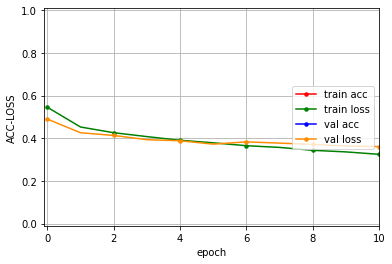

In [14]:
name = "BiLSTM-Attention"
history = LossHistory()
model.fit(x_train, y_train, batch_size=batch_size, class_weight=class_weights, epochs=epochs, verbose=1, callbacks=[history], validation_data=(x_test, y_test))
# model.save_weights(name + "_model.pkl")
history.loss_plot('epoch')

In [15]:
_, accuracy_test = model.evaluate(x_test, y_test)
_, accuracy_train = model.evaluate(x_train, y_train)
print('Accuracy test : %.2f' % (accuracy_test*100))
print('Accuracy train: %.2f' % (accuracy_train*100))
# storeResults("BLSTM",(accuracy_train*100),(accuracy_test*100))

250/250 [==============================] - 102s 408ms/step - loss: 0.2216 - accuracy: 0.8947
Accuracy test : 84.70
Accuracy train: 89.47


In [16]:
values = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print("Accuracy: ", values[1])
predictions = (model.predict(x_test, batch_size=batch_size)).round()

tn, fp, fn, tp = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)).ravel()
print('False positive rate(FP): ', fp / (fp + tn))
print('False negative rate(FN): ', fn / (fn + tp))
recall = tp / (tp + fn)
print('Recall: ', recall)
precision = tp / (tp + fp)
print('Precision: ', precision)
print('F1 score: ', (2 * precision * recall) / (precision + recall))

20/20 [==============================] - 19s 936ms/step - loss: 0.4363 - accuracy: 0.8470
Accuracy:  0.847000002861023
20/20 [==============================] - 17s 806ms/step
False positive rate(FP):  0.128
False negative rate(FN):  0.178
Recall:  0.822
Precision:  0.8652631578947368
F1 score:  0.8430769230769231


In [17]:
!cp /content/acc_loss.pdf /content/drive/MyDrive/Submit/NT522_Project/acc_loss.pdf

In [18]:
print(tn, fp, fn, tp)

872 128 178 822
